Name: Devrim ÇAVUŞOĞLU

Student Id: 2010023

In [82]:
"""
This part is devoted to utilities/helper functions that are usually
shared between all tasks.
"""

from functools import wraps
from time import time
from typing import Tuple
from pathlib import Path

import numpy as np
import PIL.Image
from PIL import ImageDraw
from scipy.signal import convolve2d


PROJECT_ROOT = Path.cwd()
RSC_DIR = PROJECT_ROOT / "rsc"


def timing(f):
    """
    A decorator to be used for computing runtime of functions.
    Taken from: https://stackoverflow.com/a/27737385
    """
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r | took: %2.4f sec' % (f.__name__, te-ts))
        return result
    return wrap


def pillow2numpy(a: PIL.Image.Image) -> np.ndarray:
    return np.array(a)


def numpy2pillow(a: np.ndarray) -> PIL.Image.Image:
    return PIL.Image.fromarray(a)
    

def get_top10(img: np.ndarray, scores: np.ndarray):
    if img.shape != scores.shape:
        raise ValueError(f"Image and scores shapes do not match. Image: {img.shape} | Scores: {scores.shape}")
    
    corners = np.zeros_like(img, dtype=np.uint8)
    ind_x, ind_y = np.unravel_index(np.argsort(scores, axis=None), scores.shape)
    corners[ind_x[-10:], ind_y[-10:]] = 1
    return corners


def compute_gradients(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    pass


def load_image(filename: str, grayscale: bool = True) -> np.ndarray:
    img = PIL.Image.open(RSC_DIR / filename)
    if grayscale:
        img = img.convert('L')
    return pillow2numpy(img)


def draw_img_corners(pil_img: PIL.Image.Image, corners: np.ndarray):
    idx_y, idx_x = np.where(corners > 0)
    draw = ImageDraw.Draw(pil_img)
    for x, y in zip(idx_x, idx_y):
#         draw.text((x, y), "x", "red", align="center")
        draw.ellipse([x-1,y-1,x+1,y+1], outline="red", width=1)
    return pil_img


def image_grid(imgs, rows, cols):
    """
    Taken from https://stackoverflow.com/a/65583584/7871601
    """
    assert len(imgs) == rows*cols
    rgb_padding = ((2, 2), (2, 2), (0, 0))

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        # Pad each image to create a grid line by each cell to 
        # distinguish the corners on neighbouring edges.
        np_img = pillow2numpy(img)
        np_img = np.pad(np_img, rgb_padding, constant_values=255) 
        pil_img = numpy2pillow(np_img)
        grid.paste(numpy2pillow(np_img), box=(i%cols*w, i//cols*h))
    return grid


def draw_corners_on_fixtures(func: callable):
    pil_imgs = []
    for img_path in RSC_DIR.glob("*"):
        img = PIL.Image.open(img_path)
        np_img = pillow2numpy(img.convert("L"))
        corners = func(np_img)
        pil_img = draw_img_corners(img, corners)
        pil_imgs.append(pil_img)
    return image_grid(pil_imgs, 3, 2)

### Task 1: Naive Formula + Uniform Weighting

func:'naive_harris_vectorized' | took: 0.0180 sec
func:'naive_harris_vectorized' | took: 0.0190 sec
func:'naive_harris_vectorized' | took: 0.0160 sec
func:'naive_harris_vectorized' | took: 0.0160 sec
func:'naive_harris_vectorized' | took: 0.0190 sec
func:'naive_harris_vectorized' | took: 0.0190 sec


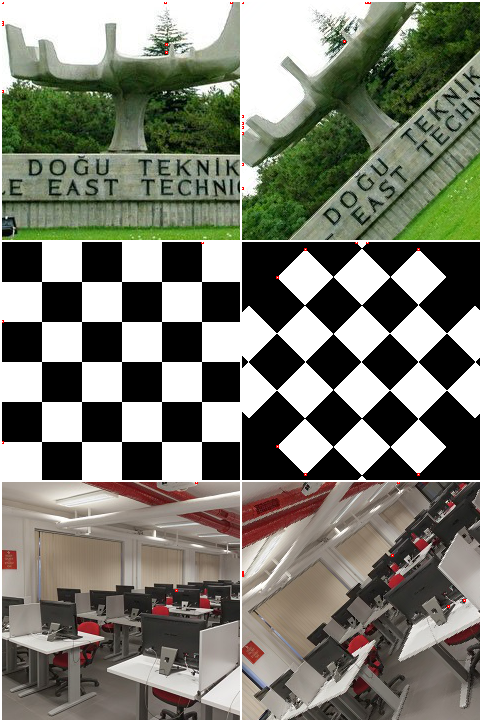

In [83]:
## Write your code here

def get_shift_filter(x, y):
    k = np.zeros((3,3))
    k[y+1, x+1] = 1
    return k


def compute_vectorized_ssd(img: np.ndarray):
    ssd = 0
    for u in range(-1, 2):
        for v in range(-1, 2):
            if (u, v) == (0, 0):
                continue
            shifted_img = convolve2d(img, get_shift_filter(u, v), mode="same")
            ssd += np.square(shifted_img - img)
    return ssd.astype(int)


def compute_ssd(img: np.ndarray, pos: Tuple[int, int]):
    x, y = pos    
    ssd = 0
    for u in range(-1, 2):
        for v in range(-1, 2):
            if (u, v) == (0, 0):
                continue
            # Need to cast higher bit integer types to encounter overflow
            ssd += np.square(img[x+u,y+v].astype(np.int32) - img[x,y].astype(np.int32))
    return ssd.astype(int)



@timing
def naive_harris(img: np.ndarray):
    """
    Implements naive harris method by looping over all pixels.
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    m, n = img.shape
    ssds = np.zeros_like(img, dtype=float)
    img = np.pad(img, 1)  # zero pad for convenience
    for x in range(1, m+1):
        for y in range(1, n+1):
            ssds[x-1, y-1] = compute_ssd(img, (x,y))
    
    img = img[1:-1, 1:-1]  # unpad
    return get_top10(img, ssds)

@timing
def naive_harris_vectorized(img: np.ndarray):
    """
    Implements naive Harris method by utilizing convolution on image. Unlike 
    `naive_harris()`, this function shifts image in 8 directions by convolution, 
    and then use the resulting shifted images to compute pixel SSDs in a 
    vectorized way.
    """
    if img.ndim != 2:
        raise ValueError("Image must be a given in grayscale as 2d array.")
    
    ssds = compute_vectorized_ssd(img)
    corners = get_top10(img, ssds)
    return corners



# img = load_image("agac.png")
# corners = naive_harris_vectorized(img)
# draw_img_corners(numpy2pillow(img), corners)
# np.where(corners > 0)
# ssd_naive = naive_harris(img)
# assert np.array_equal(ssd_vectorized, ssd_naive)
# PIL.Image.fromarray(np.hstack([img, corners*255]))
draw_corners_on_fixtures(naive_harris_vectorized)

In [84]:
## This part is for discussion



### Task2: Naive Formula + Uniform Weighting + Non-Maximum Suppression

In [ ]:
## Write your code here


In [ ]:
## This part is for discussion



### Task3: Taylor's Approximation + Uniform Weighting + Non-Maximum Suppression

In [ ]:
## Write your code here


In [ ]:
## This part is for discussion



### Task 4: Smaller Eigenvalue as corner score + Uniform Weighting + Non-Maximum Suppression

In [ ]:
## Write your code here


In [ ]:
## This part is for discussion



### Task 5: R function as corner score + Uniform Weighting + Non-Maximum Suppression

In [ ]:
## Write your code here


In [ ]:
## This part is for discussion



### Task 6: R function with fast windowing based on fitering + Uniform Weighting + Non-Maximum Suppression

In [ ]:
## Write your code here


In [ ]:
## This part is for discussion



### Task 7: R function with fast windowing based on fitering + Gaussian Weighting + Non-Maximum Suppression

In [ ]:
## Write your code here


In [ ]:
## This part is for discussion

